<a href="https://colab.research.google.com/github/tomonari-masada/course2021-sml/blob/main/09_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 糖尿病をロジスティック回帰で予測してみる

* 有名なPima Indians Diabetes Databaseを使う

 * https://www.kaggle.com/uciml/pima-indians-diabetes-database

## 1) データの読み込み

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.model_selection import StratifiedKFold

%config InlineBackend.figure_format = 'retina'

In [2]:
diabetes = pd.read_csv('/content/drive/MyDrive/2021Courses/SML/diabetes.csv')

In [3]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
y = diabetes['Outcome']
X = diabetes.drop('Outcome', axis=1)

In [6]:
X.shape

(768, 8)

In [7]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


## 2) 訓練データ、テストデータに分割

* この分割は変えないようにしてください。

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 123)

* 以下、訓練データ部分を使って、交差検証によって良いモデルを探す。

---



## 3) デフォルト設定のロジスティック回帰をベースラインとみなしてテストデータでの評価値を得る


In [9]:
logreg_baseline = LogisticRegression(random_state=123)
logreg_baseline.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

* `max_iter`が小さいとの警告が出ているので、増やして学習しなおし。

In [10]:
logreg_baseline = LogisticRegression(max_iter=1000, random_state=123)
logreg_baseline.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

* 大丈夫だったので、テストデータでの最終評価値を得る。

In [11]:
print(f'test score: {logreg_baseline.score(X_test, y_test):.4f}')

test score: 0.8103


* Area under ROC curveも計算してみる。


In [12]:
y_test_pred_proba = logreg_baseline.predict_proba(X_test)
print(f'ROC AUC: {roc_auc_score(y_test, y_test_pred_proba[:,1]):.4f}')

ROC AUC: 0.8617


* ROC curveを描いてみる。
 * https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

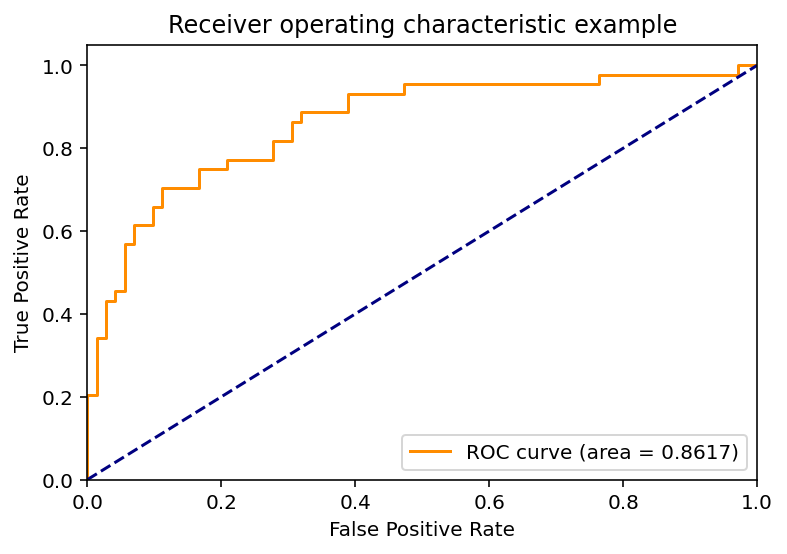

In [13]:
y_score = logreg_baseline.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

* これがベースラインなので、これより良い結果を得るべく、試行錯誤してください。
* 試行錯誤した結果として辿り着いたモデルで、最後に一回、テストデータ上での評価を行ってください。

* ロジスティック回帰についてscoreがどのように計算されているかの確認
 * thresholdが0.5である必要は、実は、ない。
 * thresholdを、交差検証で決定してもよい。

In [14]:
threshold = 0.5
((logreg_baseline.predict_proba(X_test) >= threshold)[:,1] * 1 == y_test).sum() / len(y_test)

0.8103448275862069

## 4) 交差検証しつつ試行錯誤する

* 元のデータを保存しておく。
 * 後で、訓練データだけから得られる情報を使って、訓練データも、テストデータも、変更するため。

In [15]:
X_train_original = X_train.copy()
X_test_original = X_test.copy()

### A) 最初に交差検証の準備をしておく

In [16]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

### B) 交差検証による評価のための関数を定義しておく

In [17]:
def cv(skf, X_train, y_train, args={}):
  scores = list()
  for train_index, valid_index in skf.split(X_train, y_train):

    # ロジスティック回帰の学習
    if not 'max_iter' in args:
      logreg = LogisticRegression(**args, max_iter=1000, random_state=123)
    else:
      logreg = LogisticRegression(**args, random_state=123)
    logreg.fit(X_train.iloc[train_index], y_train.iloc[train_index])

    # 検証データでの評価
    score = logreg.score(X_train.iloc[valid_index], y_train.iloc[valid_index])
    print(f'score: {score:.4f}')
    scores.append(score)

  print(f'mean score: {np.array(scores).mean():.4f}', end=' ')
  print('{', ' '.join([f'"{str(k):s}":{str(args[k]):s}' for k in args]), '}')

### C) デフォルト設定のロジスティック回帰の性能を評価する
* 交差検証で性能評価するとどうなるかを確認している。

In [18]:
cv(skf, X_train, y_train)

score: 0.8182
score: 0.7879
score: 0.7385
score: 0.7692
score: 0.7692
score: 0.7538
score: 0.7538
score: 0.7846
score: 0.7231
score: 0.7385
mean score: 0.7637 {  }


### D) BloodPressureへの対応

* まず、属性「BloodPressure」について、ヒストグラムを描いてよくよく眺める。


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


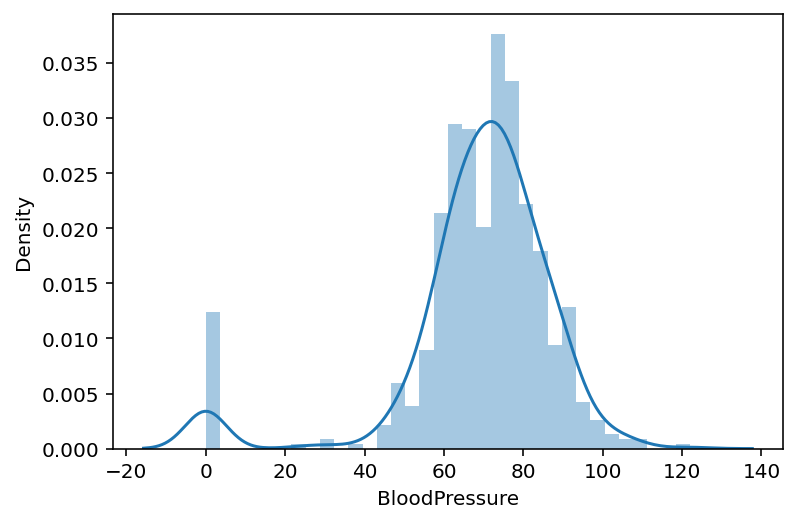

In [19]:
sns.distplot(X_train['BloodPressure'])

* 0という値がけっこうあるらしい。実は、これは欠測値。そこで、中央値で埋めることにする。
 * この前処理の仕方で正しいという保証はありません。


In [20]:
bp_median = np.median(X_train[X_train.BloodPressure != 0]['BloodPressure'])
print(f'blood pressure median: {bp_median}')
X_train = X_train.replace({'BloodPressure':0}, bp_median)

blood pressure median: 72.0


* もう一度、ヒストグラムを描く。


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


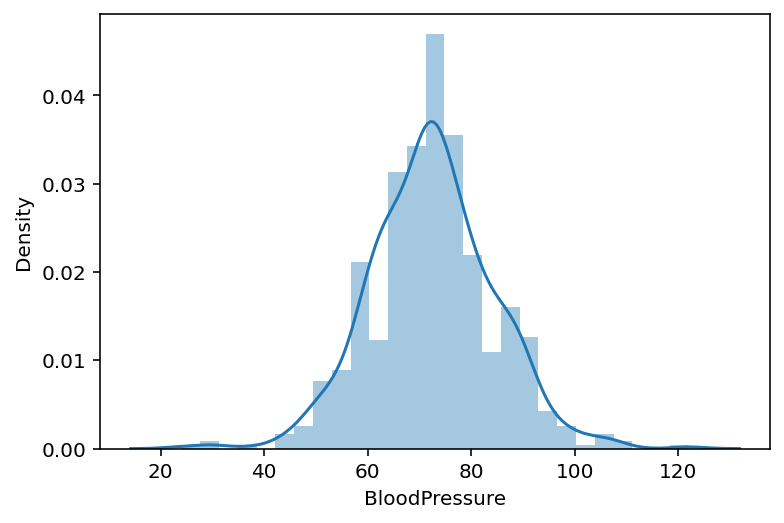

In [21]:
sns.distplot(X_train['BloodPressure'])

* 交差検証で評価する。

In [22]:
cv(skf, X_train, y_train)

score: 0.8333
score: 0.8182
score: 0.7538
score: 0.7538
score: 0.7692
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7077
score: 0.7385
mean score: 0.7698 {  }


* test dataの「BloodPressure」の欠測値も、training dataと同じ値で埋める。
 * この作業は、training dataから得られる情報しか使っていないので、ズルはしていない。


In [23]:
X_test = X_test.replace({'BloodPressure':0}, bp_median)

### E) BMIへの対応

* 次に、training dataの「BMI」のヒストグラムを描いてみる


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


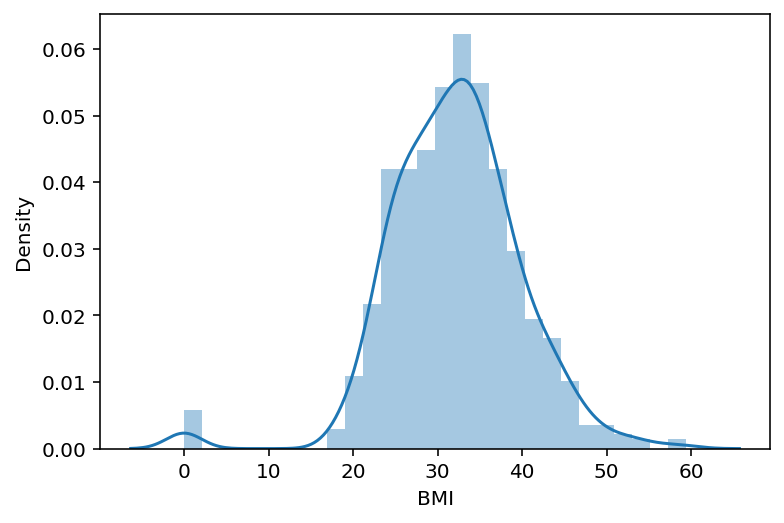

In [24]:
sns.distplot(X_train['BMI'])

* やはり欠測値の部分が0とされているようなので、先ほどと同様、中央値で埋める。


BMI median: 32.4


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


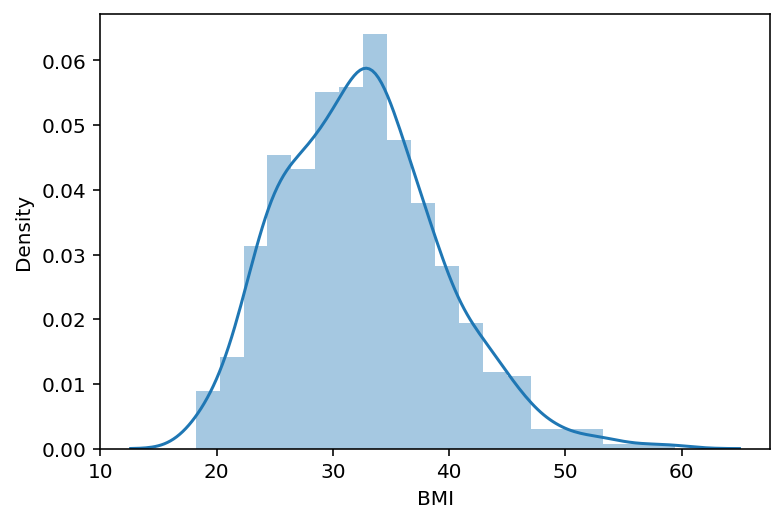

In [25]:
bmi_median = np.median(X_train[X_train.BMI != 0]['BMI'])
print(f'BMI median: {bmi_median}')
X_train = X_train.replace({'BMI':0}, bmi_median)
sns.distplot(X_train['BMI'])

In [26]:
cv(skf, X_train, y_train)

score: 0.8333
score: 0.8030
score: 0.7846
score: 0.7538
score: 0.7692
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7077
score: 0.7385
mean score: 0.7713 {  }


* test dataのBMIの欠測値も、同じ値で埋める 



In [27]:
X_test = X_test.replace({'BMI':0}, bmi_median)

### F) Glucoseへの対応

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


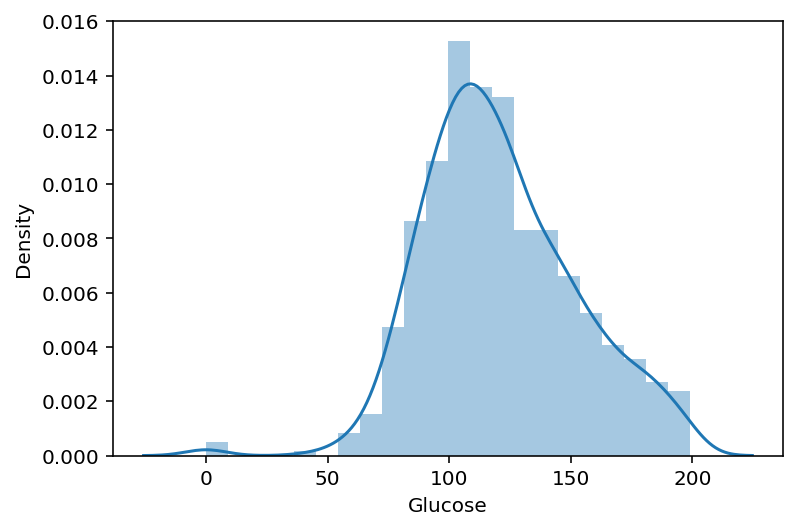

In [28]:
sns.distplot(X_train['Glucose'])

glucose median: 117.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


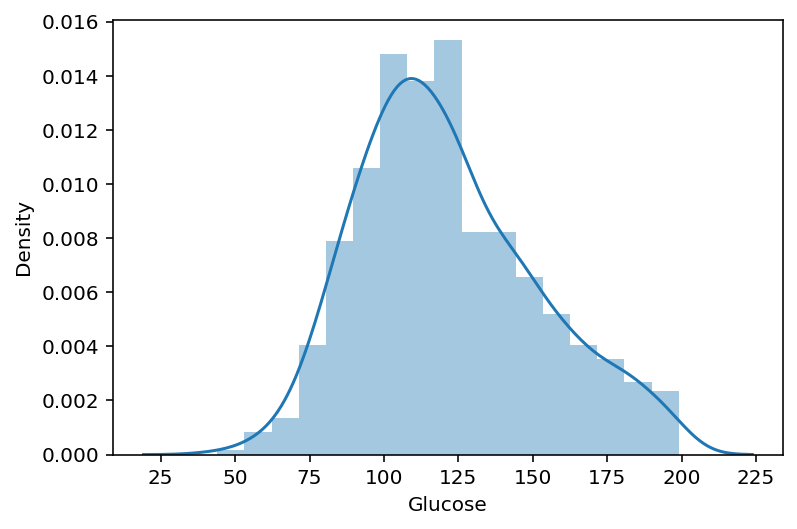

In [29]:
glucose_median = np.median(X_train[X_train.Glucose != 0]['Glucose'])
print(f'glucose median: {glucose_median}')
X_train = X_train.replace({'Glucose':0}, glucose_median)
sns.distplot(X_train['Glucose'])

In [30]:
cv(skf, X_train, y_train)

score: 0.8333
score: 0.8182
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7846
score: 0.7538
score: 0.8000
score: 0.7077
score: 0.7385
mean score: 0.7759 {  }


* test dataのGlucoseの欠測箇所も、同じ値で埋める 



In [31]:
X_test = X_test.replace({'Glucose':0}, glucose_median)

ここまでの交差検証でのベスト・スコアは0.7759。

### G) DiabetesPedigreeFunctionへの対応

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


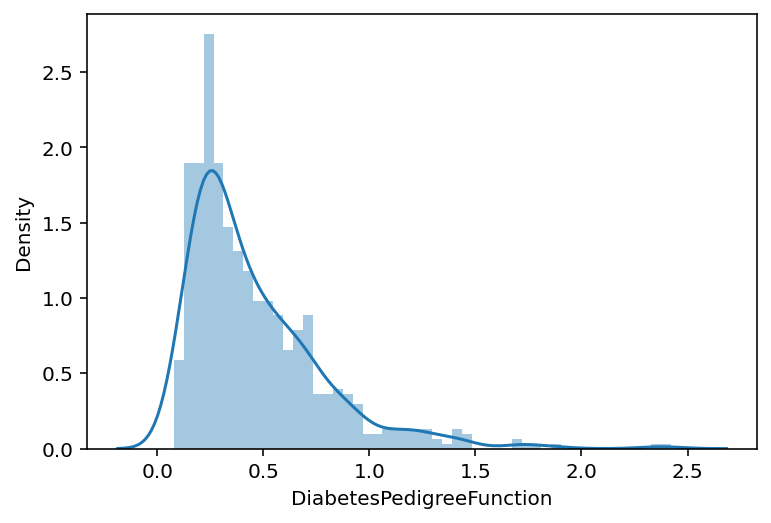

In [32]:
sns.distplot(X_train['DiabetesPedigreeFunction'], bins=50)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


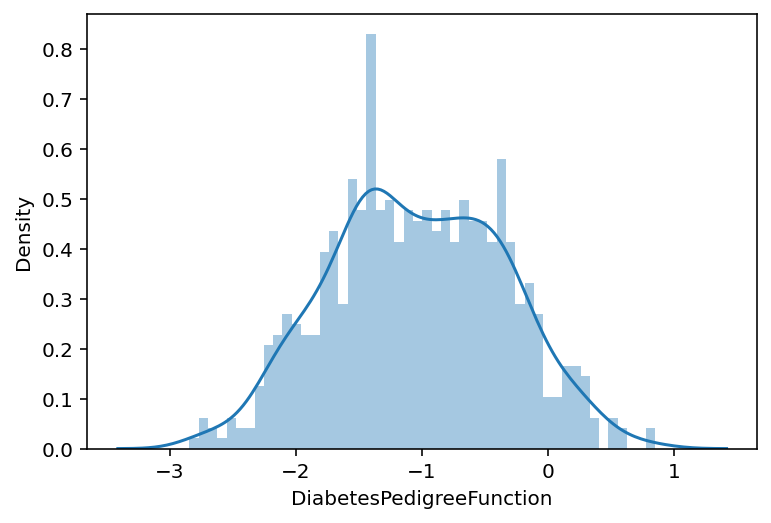

In [33]:
from scipy.stats import boxcox

X_train_boxcox = X_train.copy()
X_train_boxcox.DiabetesPedigreeFunction, maxlog = boxcox(X_train.DiabetesPedigreeFunction)
sns.distplot(X_train_boxcox['DiabetesPedigreeFunction'], bins=50)

In [34]:
cv(skf, X_train_boxcox, y_train)

score: 0.8182
score: 0.8333
score: 0.7692
score: 0.7692
score: 0.7538
score: 0.7846
score: 0.7692
score: 0.8000
score: 0.7077
score: 0.7385
mean score: 0.7744 {  }


悪くなったので不採用。

### H) SkinThicknessとInsulin: 線形回帰で欠測値を埋める

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


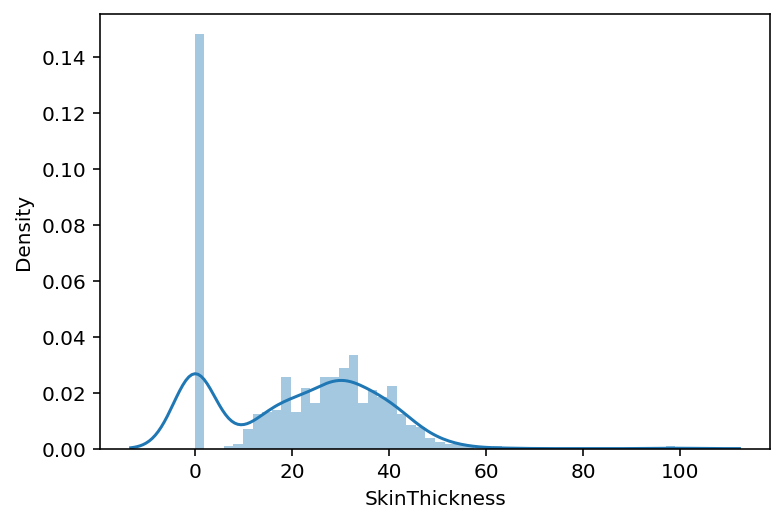

In [35]:
sns.distplot(X_train['SkinThickness'], bins=50)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


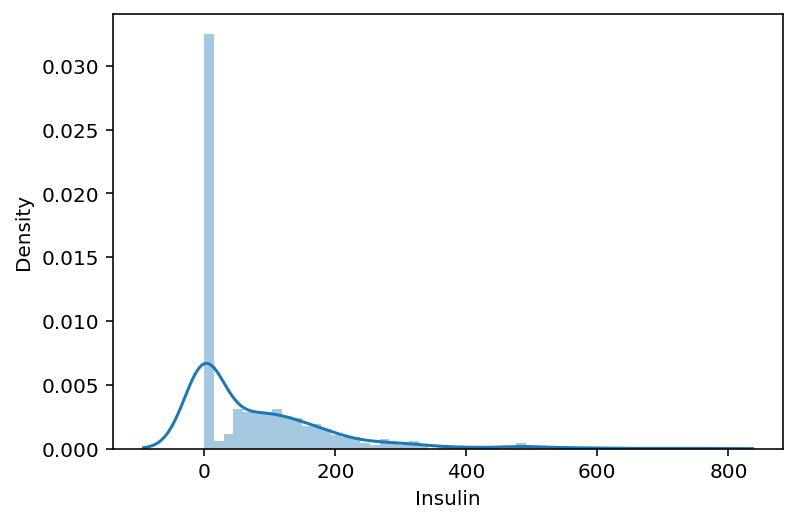

In [36]:
sns.distplot(X_train['Insulin'], bins=50)

In [37]:
(X_train['SkinThickness'] == 0).sum()

191

In [38]:
(X_train['Insulin'] == 0).sum()

314

In [39]:
((X_train['SkinThickness'] == 0) & (X_train['Insulin'] == 0)).sum()

191

In [40]:
for i in X_train.index[X_train['SkinThickness'] == 0]:
  if not i in X_train.index[X_train['Insulin'] == 0]:
    print('No')

SkinThicknessが0の個体は、必ずInsulinも0になっているらしい。

ただし、これは訓練データだけでこうなっているだけかもしれないので、この事実に依存して何かをすることはしない。

In [41]:
# LassoでSkinThicknessとInsulinの欠測部分を埋める

from sklearn.linear_model import Lasso

columns = X_train.columns[(X_train.columns != 'SkinThickness') & (X_train.columns != 'Insulin')]

for alpha in np.power(10.0, np.arange(12) - 5):

  X_train_copy = X_train.copy()

  indices = (X_train['SkinThickness'] != 0)
  reg = Lasso(alpha=alpha)
  reg.fit(X_train.loc[indices, columns], X_train.loc[indices, 'SkinThickness'])
  X_train_copy.loc[~ indices, 'SkinThickness'] = reg.predict(X_train.loc[~ indices, columns])

  indices = (X_train['Insulin'] != 0)
  reg = Lasso(alpha=alpha)
  reg.fit(X_train.loc[indices, columns], X_train.loc[indices, 'Insulin'])
  X_train_copy.loc[~ indices, 'Insulin'] = reg.predict(X_train.loc[~ indices, columns])

  print('-'*8, alpha, '-'*16)
  cv(skf, X_train_copy, y_train)

-------- 1e-05 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 0.0001 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 0.001 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 0.01 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 0.1 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 1.0 ---------

In [42]:
# Ridge回帰でSkinThicknessとInsulinの欠測部分を埋める

from sklearn.linear_model import Ridge

columns = X_train.columns[(X_train.columns != 'SkinThickness') & (X_train.columns != 'Insulin')]

for alpha in np.power(10.0, np.arange(12) - 5):

  X_train_copy = X_train.copy()

  indices = (X_train['SkinThickness'] != 0)
  reg = Ridge(alpha=alpha)
  reg.fit(X_train.loc[indices, columns], X_train.loc[indices, 'SkinThickness'])
  X_train_copy.loc[~ indices, 'SkinThickness'] = reg.predict(X_train.loc[~ indices, columns])

  indices = (X_train['Insulin'] != 0)
  reg = Ridge(alpha=alpha)
  reg.fit(X_train.loc[indices, columns], X_train.loc[indices, 'Insulin'])
  X_train_copy.loc[~ indices, 'Insulin'] = reg.predict(X_train.loc[~ indices, columns])

  print('-'*8, alpha, '-'*16)
  cv(skf, X_train_copy, y_train)

-------- 1e-05 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 0.0001 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 0.001 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 0.01 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 0.1 ----------------
score: 0.8182
score: 0.8030
score: 0.7538
score: 0.7538
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7729 {  }
-------- 1.0 ---------

悪くなったので不採用。

### I) SkinThicknessとInsulin: それぞれk-近傍法で値を埋める

In [43]:
# k-NNでSkinThicknessの欠測部分を埋める

from sklearn.neighbors import KNeighborsClassifier

columns = X_train.columns[(X_train.columns != 'SkinThickness') & (X_train.columns != 'Insulin')]

for k in range(1, 21):

  X_train_copy = X_train.copy()

  indices = (X_train['SkinThickness'] != 0)
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train.loc[indices, columns], X_train.loc[indices, 'SkinThickness'])
  X_train_copy.loc[~ indices, 'SkinThickness'] = knn.predict(X_train.loc[~ indices, columns])

  indices = (X_train['Insulin'] != 0)
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train.loc[indices, columns], X_train.loc[indices, 'Insulin'])
  X_train_copy.loc[~ indices, 'Insulin'] = knn.predict(X_train.loc[~ indices, columns])

  print('-'*8, k, '-'*16)
  cv(skf, X_train_copy, y_train)

-------- 1 ----------------
score: 0.8333
score: 0.7727
score: 0.7692
score: 0.7538
score: 0.7846
score: 0.7538
score: 0.7692
score: 0.8154
score: 0.7077
score: 0.7385
mean score: 0.7698 {  }
-------- 2 ----------------
score: 0.8333
score: 0.7879
score: 0.7846
score: 0.7385
score: 0.8000
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7231
score: 0.7538
mean score: 0.7744 {  }
-------- 3 ----------------
score: 0.8333
score: 0.7879
score: 0.7692
score: 0.7538
score: 0.7846
score: 0.7692
score: 0.7692
score: 0.8000
score: 0.7231
score: 0.7385
mean score: 0.7729 {  }
-------- 4 ----------------
score: 0.8333
score: 0.7879
score: 0.7692
score: 0.7538
score: 0.7846
score: 0.7692
score: 0.7692
score: 0.7846
score: 0.7231
score: 0.7385
mean score: 0.7714 {  }
-------- 5 ----------------
score: 0.8333
score: 0.7879
score: 0.7846
score: 0.7385
score: 0.7846
score: 0.7692
score: 0.7692
score: 0.8154
score: 0.7077
score: 0.7385
mean score: 0.7729 {  }
-------- 6 ----------------
score: 0.833

In [44]:
# k=9を採用

k = 9

X_train_copy = X_train.copy()

indices = (X_train['SkinThickness'] != 0)
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train.loc[indices, columns], X_train.loc[indices, 'SkinThickness'])
X_train_copy.loc[~ indices, 'SkinThickness'] = knn.predict(X_train.loc[~ indices, columns])

indices = (X_train['Insulin'] != 0)
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train.loc[indices, columns], X_train.loc[indices, 'Insulin'])
X_train_copy.loc[~ indices, 'Insulin'] = knn.predict(X_train.loc[~ indices, columns])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


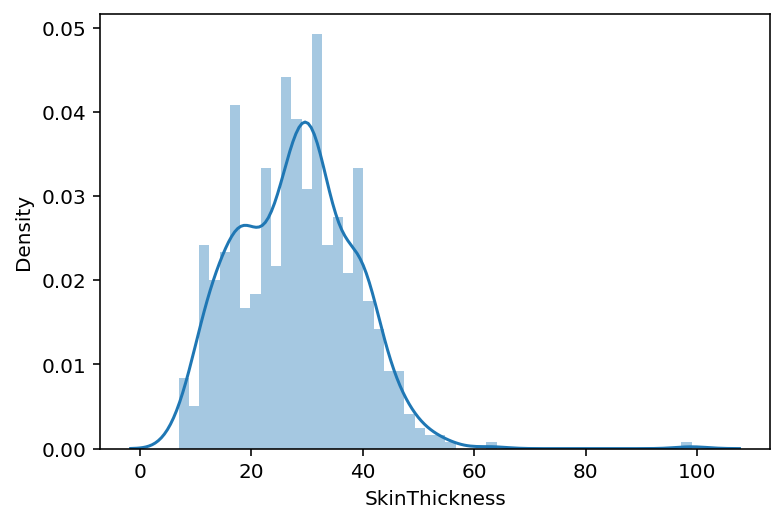

In [45]:
sns.distplot(X_train_copy['SkinThickness'], bins=50)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


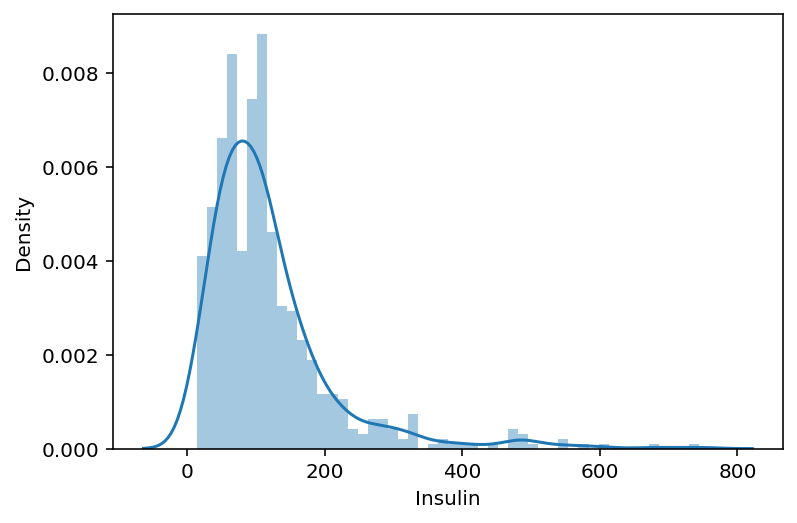

In [46]:
sns.distplot(X_train_copy['Insulin'], bins=50)

In [47]:
cv(skf, X_train_copy, y_train)

score: 0.8333
score: 0.8182
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7846
score: 0.7692
score: 0.8154
score: 0.7077
score: 0.7385
mean score: 0.7790 {  }


In [48]:
# k=9を使って、テストデータの欠測箇所も埋めておく

X_test_copy = X_test.copy()

k = 9

indices = (X_train['SkinThickness'] != 0)
test_missing = (X_test['SkinThickness'] == 0)
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train.loc[indices, columns], X_train.loc[indices, 'SkinThickness'])
X_test_copy.loc[test_missing, 'SkinThickness'] = knn.predict(X_test.loc[test_missing, columns])

indices = (X_train['Insulin'] != 0)
test_missing = (X_test['Insulin'] == 0)
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train.loc[indices, columns], X_train.loc[indices, 'Insulin'])
X_test_copy.loc[test_missing, 'Insulin'] = knn.predict(X_test.loc[test_missing, columns])

In [49]:
print((X_test_copy.SkinThickness == 0).sum())
print((X_test_copy.Insulin == 0).sum())

0
0


* 分類性能が良くなったので、埋めた後のデータセットを採用する。

In [50]:
X_train = X_train_copy
X_test = X_test_copy

In [51]:
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000
mean,3.796012,121.512270,72.374233,27.943252,117.987730,32.515184,0.460816,33.291411
std,3.325152,30.146975,11.921575,10.474671,94.510997,6.801301,0.321493,11.801392
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,100.000000,64.000000,19.000000,61.000000,27.500000,0.238000,24.000000
50%,3.000000,117.000000,72.000000,28.000000,100.000000,32.400000,0.364500,29.000000
75%,6.000000,141.000000,80.000000,35.000000,140.000000,36.600000,0.605000,41.000000
max,17.000000,199.000000,122.000000,99.000000,744.000000,59.400000,2.420000,81.000000


### J) スケーラーを使ってみる。

In [52]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_temp = X_train.copy()
X_train_temp[X_train.columns] = scaler.transform(X_train)
cv(skf, X_train_temp, y_train)

score: 0.8030
score: 0.8030
score: 0.7538
score: 0.7385
score: 0.7846
score: 0.7692
score: 0.7231
score: 0.7846
score: 0.7231
score: 0.7385
mean score: 0.7621 {  }


In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_temp = X_train.copy()
X_train_temp[X_train.columns] = scaler.transform(X_train)
cv(skf, X_train_temp, y_train)

score: 0.8182
score: 0.8182
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7692
score: 0.7692
score: 0.8000
score: 0.7077
score: 0.7385
mean score: 0.7744 {  }


いずれも不採用。

### K) 正則化パラメータCをチューニングする。

In [54]:
for C in np.power(10.0, np.arange(13) - 5):
  cv(skf, X_train, y_train, {'C':C})

score: 0.7273
score: 0.7727
score: 0.7385
score: 0.6923
score: 0.7846
score: 0.7846
score: 0.6769
score: 0.7385
score: 0.7231
score: 0.7231
mean score: 0.7362 { "C":1e-05 }
score: 0.8485
score: 0.8182
score: 0.7692
score: 0.6769
score: 0.7538
score: 0.7538
score: 0.6923
score: 0.7538
score: 0.7231
score: 0.7538
mean score: 0.7544 { "C":0.0001 }
score: 0.8182
score: 0.8030
score: 0.7692
score: 0.7385
score: 0.7692
score: 0.7846
score: 0.7077
score: 0.7846
score: 0.7385
score: 0.7692
mean score: 0.7683 { "C":0.001 }
score: 0.8333
score: 0.7727
score: 0.7692
score: 0.7538
score: 0.7692
score: 0.7692
score: 0.7538
score: 0.8000
score: 0.7077
score: 0.7538
mean score: 0.7683 { "C":0.01 }
score: 0.8333
score: 0.7879
score: 0.7692
score: 0.7538
score: 0.7846
score: 0.7538
score: 0.7538
score: 0.8154
score: 0.7077
score: 0.7538
mean score: 0.7714 { "C":0.1 }
score: 0.8333
score: 0.8182
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7846
score: 0.7692
score: 0.8154
score: 0.7077
score: 0.73

In [55]:
for C in np.power(10.0, np.arange(13) - 5):
  cv(skf, X_train, y_train, {'C':C, 'penalty':'l1', 'solver':'liblinear', 'max_iter':5000})

score: 0.6515
score: 0.6515
score: 0.6615
score: 0.6615
score: 0.6615
score: 0.6615
score: 0.6615
score: 0.6615
score: 0.6462
score: 0.6462
mean score: 0.6565 { "C":1e-05 "penalty":l1 "solver":liblinear "max_iter":5000 }
score: 0.6515
score: 0.6515
score: 0.6615
score: 0.6615
score: 0.6615
score: 0.6615
score: 0.6615
score: 0.6615
score: 0.6462
score: 0.6462
mean score: 0.6565 { "C":0.0001 "penalty":l1 "solver":liblinear "max_iter":5000 }
score: 0.6364
score: 0.6515
score: 0.6615
score: 0.6308
score: 0.6769
score: 0.6769
score: 0.6154
score: 0.6615
score: 0.6615
score: 0.6308
mean score: 0.6503 { "C":0.001 "penalty":l1 "solver":liblinear "max_iter":5000 }
score: 0.7121
score: 0.7273
score: 0.7231
score: 0.6615
score: 0.6308
score: 0.6769
score: 0.6000
score: 0.6769
score: 0.6923
score: 0.7231
mean score: 0.6824 { "C":0.01 "penalty":l1 "solver":liblinear "max_iter":5000 }
score: 0.7576
score: 0.7424
score: 0.7231
score: 0.7231
score: 0.6923
score: 0.7077
score: 0.6615
score: 0.7077
scor

デフォルト値`C=1.0`を採用。

In [56]:
cv(skf, X_train, y_train)

score: 0.8333
score: 0.8182
score: 0.7846
score: 0.7538
score: 0.7846
score: 0.7846
score: 0.7692
score: 0.8154
score: 0.7077
score: 0.7385
mean score: 0.7790 {  }


### L) 分類のthresholdをチューニングしてみる

In [57]:
def cv_threshold(skf, X_train, y_train, threshold=0.5, args={}):
  scores = list()
  for train_index, valid_index in skf.split(X_train, y_train):

    # ロジスティック回帰の学習
    if not 'max_iter' in args:
      logreg = LogisticRegression(**args, max_iter=1000, random_state=123)
    else:
      logreg = LogisticRegression(**args, random_state=123)
    logreg.fit(X_train.iloc[train_index], y_train.iloc[train_index])

    # 検証データでの評価（thresholdの値を利用している）
    X_valid = X_train.iloc[valid_index]
    y_valid = y_train.iloc[valid_index]
    score = ((logreg.predict_proba(X_valid) >= threshold)[:,1] * 1 == y_valid).sum() / len(y_valid)
    scores.append(score)

  print(f'{threshold:.2f} ; mean score: {np.array(scores).mean():.4f}', end=' ')
  print('{', ' '.join([f'"{str(k):s}":{str(args[k]):s}' for k in args]), '}')

In [58]:
for threshold in np.arange(4, 7, 0.5) * 0.1:
  cv_threshold(skf, X_train_original, y_train, threshold=threshold)

0.40 ; mean score: 0.7560 {  }
0.45 ; mean score: 0.7652 {  }
0.50 ; mean score: 0.7637 {  }
0.55 ; mean score: 0.7636 {  }
0.60 ; mean score: 0.7590 {  }
0.65 ; mean score: 0.7606 {  }


In [59]:
for threshold in np.arange(4, 7, 0.5) * 0.1:
  cv_threshold(skf, X_train, y_train, threshold=threshold)

0.40 ; mean score: 0.7652 {  }
0.45 ; mean score: 0.7713 {  }
0.50 ; mean score: 0.7790 {  }
0.55 ; mean score: 0.7668 {  }
0.60 ; mean score: 0.7590 {  }
0.65 ; mean score: 0.7637 {  }


* 以上をまとめると、モデルはデフォルトのままでよく、データの欠損に対処しただけ。

### M) テストデータで最終評価

In [60]:
logreg = LogisticRegression(max_iter=1000, random_state=123)
logreg.fit(X_train, y_train)
print('test score: {:.4f}'.format(logreg.score(X_test, y_test)))

test score: 0.7759


* 分類精度だけを見ると、欠損に対処しないほうがよかった、という結論になるが・・・

In [61]:
y_test_pred_proba = logreg.predict_proba(X_test)
print('ROC AUC: {:.4f}'.format(roc_auc_score(y_test, y_test_pred_proba[:,1])))

ROC AUC: 0.8797


* AUCは改善されている。

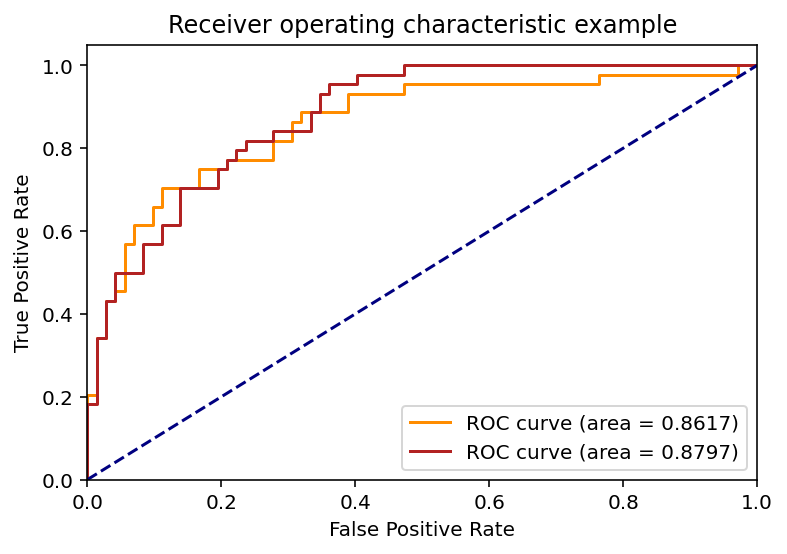

In [62]:
y_score = logreg_baseline.decision_function(X_test_original) # ベースラインには元のテストデータを使う
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

y_score_ours = logreg.decision_function(X_test)
fpr_ours, tpr_ours, _ = roc_curve(y_test, y_score_ours)
roc_auc_ours = auc(fpr_ours, tpr_ours)

plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot(fpr_ours, tpr_ours, color='firebrick', label=f'ROC curve (area = {roc_auc_ours:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")